In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import json
import pymongo
from pymongo import MongoClient
import pprint as pp
! pip install normalise
import nltk
nltk.download('names')
nltk.download('brown')

import numpy as np
import multiprocessing as mp

import string
import spacy 
import en_core_web_sm
from nltk.tokenize import word_tokenize
from sklearn.base import TransformerMixin, BaseEstimator
from normalise import normalise
import re

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Flatten, LSTM, Conv1D, MaxPooling1D, Dropout, Activation,GRU, SimpleRNN
from keras.layers.embeddings import Embedding
from keras.initializers import Constant
from keras import layers

     |████████████████████████████████| 15.7MB 2.4MB/s 
[nltk_data] Downloading package names to /root/nltk_data...
[nltk_data]   Unzipping corpora/names.zip.
[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.semi_supervised.label_propagation module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.semi_supervised. Anything that cannot be imported from sklearn.semi_supervised is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator LabelPropagation from version 0.18 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
Using TensorFlow backend.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
cd '/content/drive/My Drive/minor2/Hate-Speech-Content-Moderation/'

/content/drive/My Drive/minor2/Hate-Speech-Content-Moderation


In [4]:
df1=pd.read_excel('quora.xlsx')
#df1.drop(['level_0','index','Unnamed: 0'],axis=1,inplace=True)
df1.head()

,qid,text,label
0,8eeb2fa6a60d93c5ce3c,"What is the difference between real, true, act...",0
1,420689e2da77a9254362,Can an applicant with JEST score in PhD merit ...,0
2,b4d8ce47a727326a8916,How can I get the syllabus of JEE Advanced for...,0
3,197be9aa5fbef88659ee,What is fee structure of KLE Sheshagiri Colleg...,0
4,a05cc194d3952fce5856,How do I pick few wines that will go with food...,0


In [5]:
np.mean(df1['label'])

0.29186533737899145

In [0]:
text=df1['text']
labels=df1['label']

In [0]:
nlp = en_core_web_sm.load()


class TextPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self,
                 variety="BrE",
                 user_abbrevs={},
                 n_jobs=1):
        """
        Text preprocessing transformer includes steps:
            1. Text normalization
            2. Punctuation removal
            3. Stop words removal
            4. Lemmatization
        
        variety - format of date (AmE - american type, BrE - british format) 
        user_abbrevs - dict of user abbreviations mappings (from normalise package)
        n_jobs - parallel jobs to run
        """
        self.variety = variety
        self.user_abbrevs = user_abbrevs
        self.n_jobs = n_jobs

    def fit(self, X, y=None):
        return self

    def transform(self, X, *_):
        X_copy = X.copy()
        return X_copy.apply(self._preprocess_text)

    def _preprocess_part(self, part):
        return part.apply(self._preprocess_text)

    def _preprocess_text(self, text):
        text=self._clean_text(text)
        normalized_text = self._normalize(text)
        doc = nlp(normalized_text)
        removed_punct = self._remove_punct(doc)
        removed_stop_words = self._remove_stop_words(removed_punct)
        return self._lemmatize(removed_stop_words)

    def _normalize(self, text):
        # some issues in normalise package
        try:
            return ' '.join(normalise(text, variety=self.variety, user_abbrevs=self.user_abbrevs, verbose=False))
        except:
            return text

    def _remove_punct(self, doc):
        return [t for t in doc if t.text not in string.punctuation]

    def _remove_stop_words(self, doc):
        return [t for t in doc if not t.is_stop]

    def _lemmatize(self, doc):
        return ' '.join([t.lemma_ for t in doc])
    
    
    def _clean_text(self,text):
      replace_1 = re.compile("(\.)|(\;)|(\:)|(\!)|(\')|(\?)|(\,)|(\")|(\()|(\))|(\[)|(\])")
      replace_2 = re.compile("(<br\s*/><br\s*/>)|(\-)|(\/)")
      text=re.sub(r"http\S+", "", text)
      text = replace_1.sub("", text)
      text = replace_2.sub(" ", text)
      text=re.sub('\s+',' ',text)
      return text

In [0]:
%%time
text = TextPreprocessor(n_jobs=-1).transform(df1['text'])

CPU times: user 2min 59s, sys: 1.33 s, total: 3min
Wall time: 3min


In [0]:
#X_test.iloc[:,1:]

In [0]:
#for i in X_test.iloc[:,1:].index:
#  print(df3.iloc[i,0],"  ",dataset.loc[i])

In [0]:
exdf=pd.DataFrame()
exdf['text']=["hello my \n is ./.,is tushit's \t @344$%% what are you D.R   running  doing?? please HELP!!"]
clean_ex = TextPreprocessor(n_jobs=-1).transform(exdf['text'])
print(clean_ex[0])

hello tushit @344$%% DR run HELP


In [0]:
text=text.tolist()

In [0]:
text2=[]
for i in text:
    lst=i.split()
    text2.append(lst)

In [9]:
len(text2)

13842

In [10]:
from gensim.models import Word2Vec
model_word2vec = Word2Vec(text2, size=100, window=5, min_count=5, workers=4,sg=0)
words = list(model_word2vec.wv.vocab)
print('Vocabulary size:', len(words))

Vocabulary size: 3869


In [11]:
model_word2vec.wv.save_word2vec_format('/content/drive/My Drive/minor2/Hate-Speech-Content-Moderation/trained_word2vec(quora).txt',binary=False)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [12]:
embeddings_index={}
f= open('/content/drive/My Drive/minor2/Hate-Speech-Content-Moderation/trained_word2vec(quora).txt',encoding='utf-8')
for line in f:
  values = line.split()
  word = values[0]
  coefs = np.array(values[1:])
  embeddings_index[word]=coefs
f.close

<function TextIOWrapper.close>

In [13]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
tokenizer_obj = Tokenizer()
tokenizer_obj.fit_on_texts(text2)
sequences = tokenizer_obj.texts_to_sequences(text2)
max_length = max([len(s.split()) for s in text])
word_index = tokenizer_obj.word_index
print('Found %s unique tokens.',len(word_index))
tweets_pad = pad_sequences(sequences,maxlen=max_length)

Found %s unique tokens. 28110


In [0]:
df3=pd.concat([pd.DataFrame(text),pd.DataFrame(tweets_pad)],axis=1)

In [0]:
num_words = len(word_index)+1
embedding_matrix = np.zeros((num_words,100))

for word , i in word_index.items():
  #if i > num_words:
  #  continue
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    embedding_matrix[i]=embedding_vector

In [16]:
embedding_matrix.shape

(28111, 100)

In [17]:
print(num_words)

28111


In [0]:
model = Sequential()
embedding_layer = Embedding(num_words,
                            100,
                            embeddings_initializer = Constant(embedding_matrix),
                            weights = [embedding_matrix],
                            input_length = max_length,
                            trainable=False)
model.add(embedding_layer)
model.add(layers.Conv1D(128, 5, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()












Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 28, 100)           1488700   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 24, 128)           64128     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1290      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 1,554,129
Trainable params: 65,429
Non-trainable params: 1,488,700
_________________________________________________________________


In [18]:
model = Sequential()
embedding_layer = Embedding(num_words,
                            100,
                            embeddings_initializer = Constant(embedding_matrix),
                            input_length = max_length,
                            trainable=False)
model.add(embedding_layer)
model.add(LSTM(units=100))
model.add(Dropout(.3))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 58, 100)           2811100   
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 2,891,601
Trainable params: 80,501
Non-trainable params: 2,811,100
_________________________________________________________________


In [0]:
model = Sequential()
embedding_layer = Embedding(num_words,
                            100,
                            embeddings_initializer = Constant(embedding_matrix),
                            input_length = max_length,
                            trainable=False)
model.add(embedding_layer)
model.add(GRU(units=100,dropout=0.2 , recurrent_dropout=0.2, activation='tanh'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 1250, 100)         3284900   
_________________________________________________________________
gru_1 (GRU)                  (None, 100)               60300     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 101       
Total params: 3,345,301
Trainable params: 60,401
Non-trainable params: 3,284,900
_________________________________________________________________


In [0]:
model = Sequential()
embedding_layer = Embedding(num_words,
                            100,
                            embeddings_initializer = Constant(embedding_matrix),
                            input_length = max_length,
                            trainable=False)
model.add(embedding_layer)
model.add(Flatten())
model.add(layers.Dense(10, activation='sigmoid'))
#model.add(GRU(units=100,dropout=0.2 , recurrent_dropout=0.2))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 28, 100)           1488700   
_________________________________________________________________
flatten_1 (Flatten)          (None, 2800)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 10)                28010     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 11        
Total params: 1,516,721
Trainable params: 28,021
Non-trainable params: 1,488,700
_________________________________________________________________


In [0]:
model = Sequential()
embedding_layer = Embedding(num_words,
                            100,
                            embeddings_initializer = Constant(embedding_matrix),
                            input_length = max_length,
                            trainable=False)
model.add(embedding_layer)
#model.add(Flatten())
model.add(SimpleRNN(16, dropout=.3, recurrent_dropout=.3))
model.add(layers.Dense(10, activation='sigmoid'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 28, 100)           1488700   
_________________________________________________________________
simple_rnn_5 (SimpleRNN)     (None, 16)                1872      
_________________________________________________________________
dense_13 (Dense)             (None, 10)                170       
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 11        
Total params: 1,490,753
Trainable params: 2,053
Non-trainable params: 1,488,700
_________________________________________________________________


In [0]:
from sklearn.model_selection import train_test_split
X_train, X_testing ,y_train, y_testing = train_test_split(df3, labels, test_size = 0.60, random_state = 1)

In [0]:
X_test, X_val ,y_test, y_val = train_test_split(X_testing, y_testing, test_size = 0.50, random_state = 0)

In [21]:
print('Training.....')
history=model.fit(X_train.iloc[:,1:], y_train, batch_size=256,epochs=5,validation_data=(X_val.iloc[:,1:],y_val),verbose=True)

Training.....
Train on 5536 samples, validate on 4153 samples
Epoch 1/5
5536/5536 [==============================] - 8s 1ms/step - loss: 0.6290 - accuracy: 0.6895 - val_loss: 0.6111 - val_accuracy: 0.7067
Epoch 2/5
5536/5536 [==============================] - 7s 1ms/step - loss: 0.5745 - accuracy: 0.7168 - val_loss: 0.5097 - val_accuracy: 0.7532
Epoch 3/5
5536/5536 [==============================] - 7s 1ms/step - loss: 0.5159 - accuracy: 0.7523 - val_loss: 0.4985 - val_accuracy: 0.7660
Epoch 4/5
5536/5536 [==============================] - 7s 1ms/step - loss: 0.4901 - accuracy: 0.7673 - val_loss: 0.4879 - val_accuracy: 0.7703
Epoch 5/5
5536/5536 [==============================] - 7s 1ms/step - loss: 0.4811 - accuracy: 0.7738 - val_loss: 0.4774 - val_accuracy: 0.7746


In [22]:
loss, accuracy = model.evaluate(X_test.iloc[:,1:], y_test, verbose=True)
print("Testing Accuracy:  {:.4f}".format(accuracy))

4153/4153 [==============================] - 2s 380us/step
Testing Accuracy:  0.7763


In [0]:
y_classes = model.predict_classes(X_test.iloc[:,1:])

In [0]:
dataset = pd.DataFrame({'y_test': y_test, 'y_classes': y_classes[:,0]})

In [25]:
df_x=dataset[dataset['y_test']==dataset['y_classes']]
df_x[df_x['y_classes']==0]

,y_test,y_classes
13480,0,0
4941,0,0
12488,0,0
8428,0,0
13723,0,0
...,...,...
1971,0,0
5969,0,0
7546,0,0
3085,0,0


In [26]:
dataset[dataset['y_test']==1]

,y_test,y_classes
3871,1,0
1947,1,0
10415,1,1
7387,1,0
1727,1,0
...,...,...
893,1,0
4812,1,1
7376,1,1
674,1,0


In [0]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

In [28]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, y_classes)
print('Accuracy:{}\n'.format(accuracy))
# precision tp / (tp + fp)
precision = precision_score(y_test, y_classes)
print('Precision:{}\n'.format(precision))
# recall: tp / (tp + fn)
recall = recall_score(y_test, y_classes)
print('Recall:{}\n'.format(recall))
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, y_classes)
print('F1 score:{}\n'.format(f1))
matrix = confusion_matrix(y_test, y_classes)
print("Confusion Matrix:")
print(matrix)

Accuracy:0.7763062846135323

Precision:0.6510416666666666

Recall:0.5127153404429861

F1 score:0.5736576411197797

Confusion Matrix:
[[2599  335]
 [ 594  625]]


In [0]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history,name_of_fig):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    f=plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    f.savefig(name_of_fig, bbox_inches='tight', dpi=400)

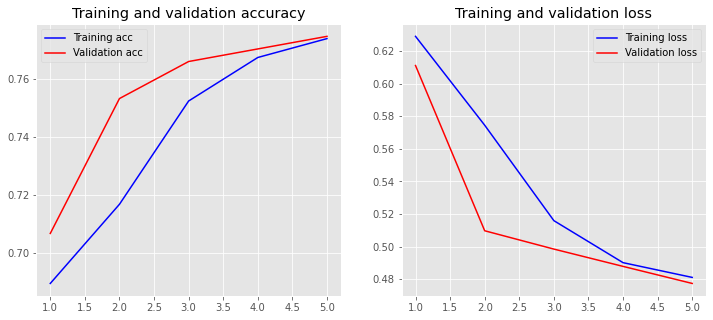

In [30]:
plot_history(history,'/content/drive/My Drive/minor2/Hate-Speech-Content-Moderation/accuracy and losses graphs(word2vec_LSTM)(quora).jpg')